## Example 07 - Using actual graphs and graph_module.py

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style
from osgeo import ogr, osr

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Vaarwegvakken"
name_graph = "Vaarwegvakken.shp"
name_graph_conv = "Vaarwegvakken - wgs84.shp"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

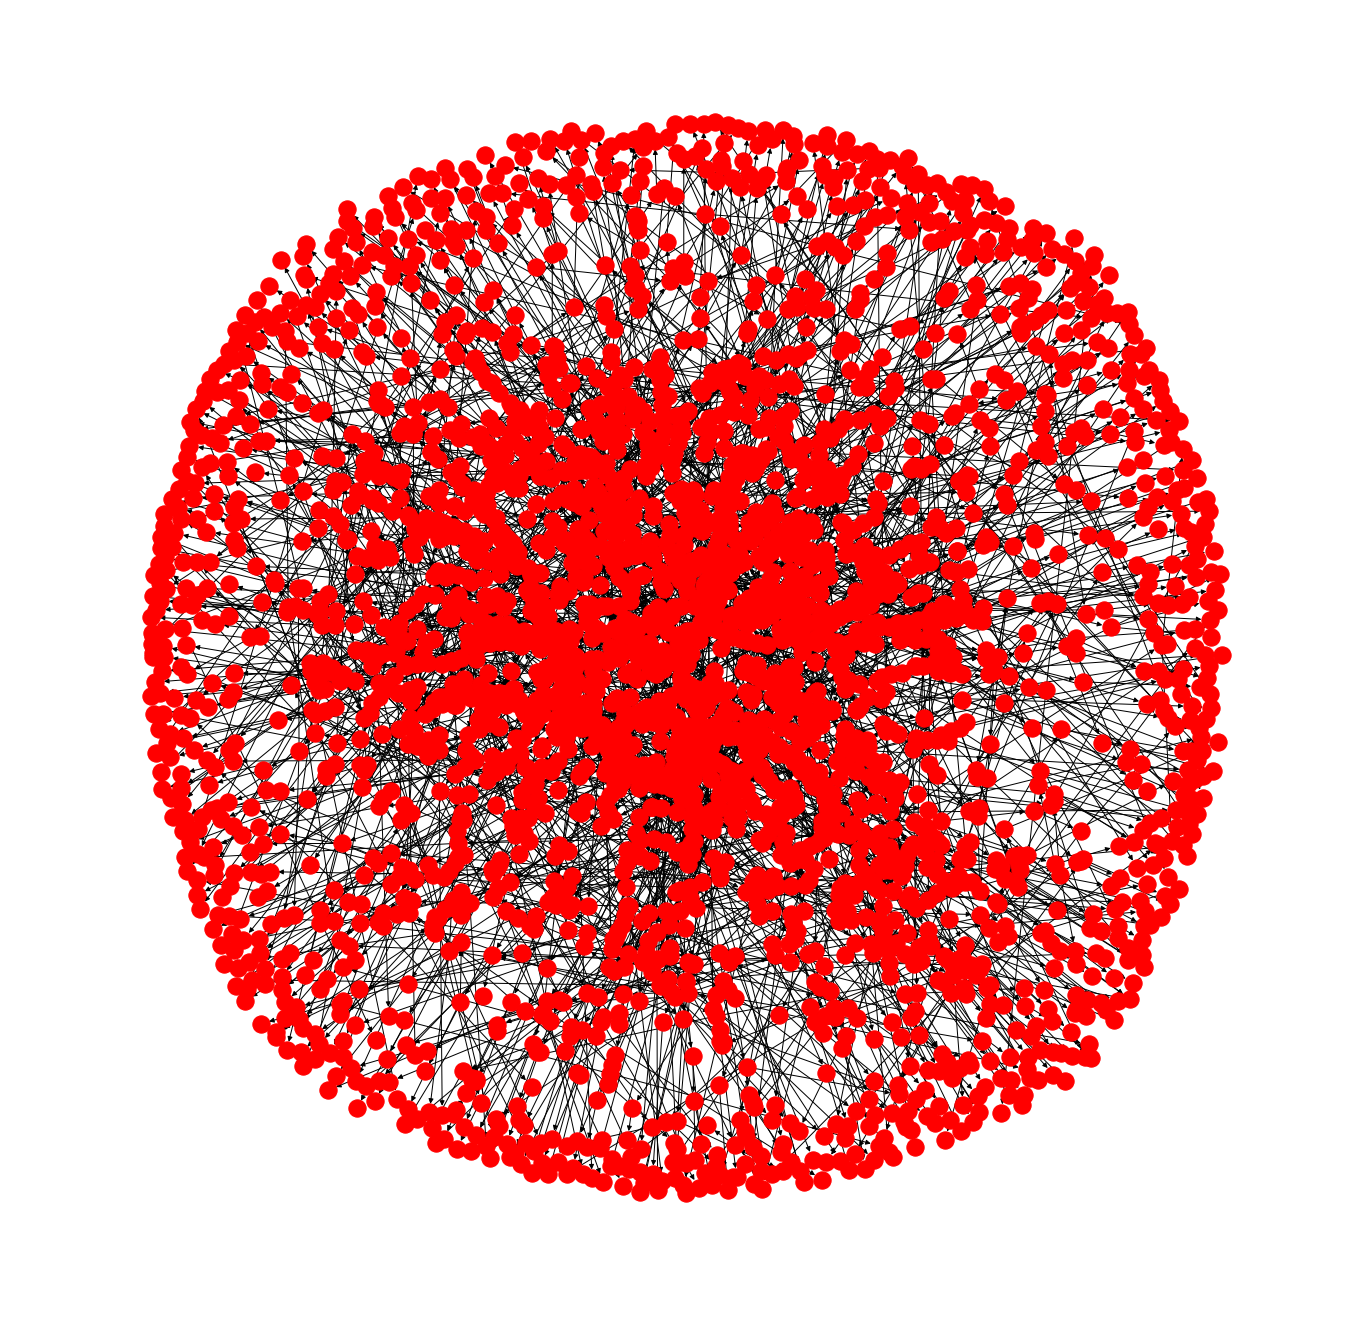

In [2]:
# Read the shape-file
FG = nx.read_shp(os.path.join(location_graph, name_graph), 
                 simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

### Convert to WGS84

In [3]:
def transform_projection(location_graph, name_graph):
    driver = ogr.GetDriverByName('ESRI Shapefile')
    dataset = driver.Open(os.path.join(location_graph, name_graph))

    # from Layer
    inSpatialRef = dataset.GetLayer().GetSpatialRef()

    # Set up the coordinate reference we want to use, WGS84 - World Geodetic System 1984
    outSpatialRef = osr.SpatialReference()
    outSpatialRef.ImportFromEPSG(4326)

    # Transform the coordinates
    transform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    
    return transform

In [4]:
def change_projection(transform, point):
    point = ogr.CreateGeometryFromWkt(str(point))
    
    point.Transform(transform)
    point.ExportToWkt()
    
    return point.GetX(), point.GetY()

In [5]:
transform = transform_projection(location_graph, name_graph)
FG_test = nx.DiGraph()

nodes_dict = {}

for i, node in enumerate(FG.nodes(data = True)):
    coordinates = change_projection(transform, shapely.geometry.Point(list(FG.nodes)[i][0], list(FG.nodes)[i][1]))
    name = "({:f}, {:f})".format(coordinates[0], coordinates[1])
    geometry = shapely.geometry.Point(coordinates[0], coordinates[1])
    
    nodes_dict[list(FG.nodes)[i]] = name
    FG_test.add_node(name, Name = name, Position = coordinates, Geometry = geometry, Old = node[1])
    
for edge in FG.edges(data = True):
    node_1 = nodes_dict[edge[0]]
    node_2 = nodes_dict[edge[1]]
    
    FG_test.add_edge(node_1, node_2, Info = edge[2])

if nx.info(FG) == nx.info(FG_test):
    print("Succes!")

Succes!


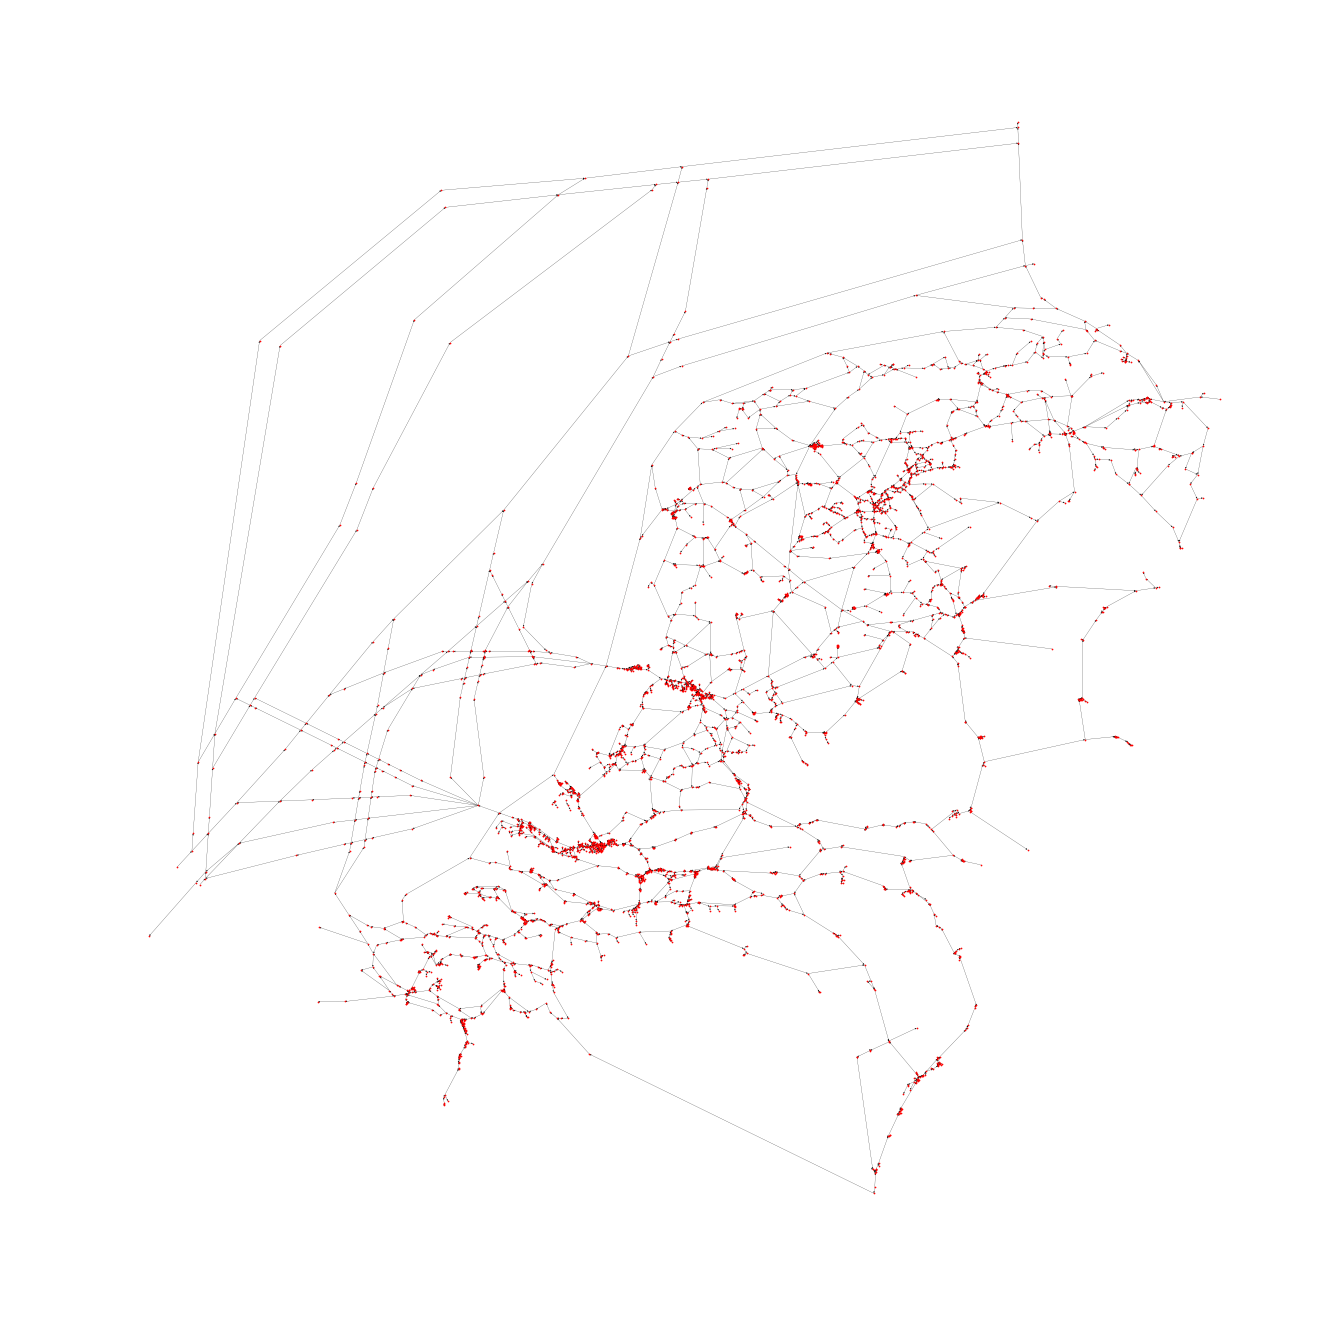

In [6]:
plt.figure(figsize=(18,18))
nx.draw(FG_test, nx.get_node_attributes(FG_test, 'Position'), node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

### Using graph module

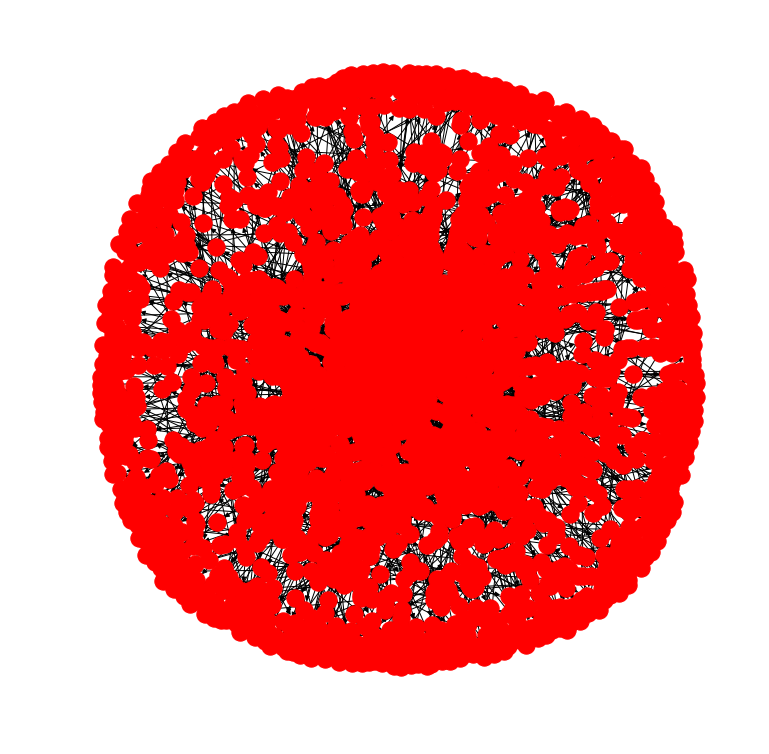

In [7]:
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)
graph.plot()

Conversion did not create an exact similar graph

Original graph
Name: 
Type: DiGraph
Number of nodes: 3336
Number of edges: 3712
Average in degree:   1.1127
Average out degree:   1.1127

New graph
Name: 
Type: DiGraph
Number of nodes: 3336
Number of edges: 7424
Average in degree:   2.2254
Average out degree:   2.2254


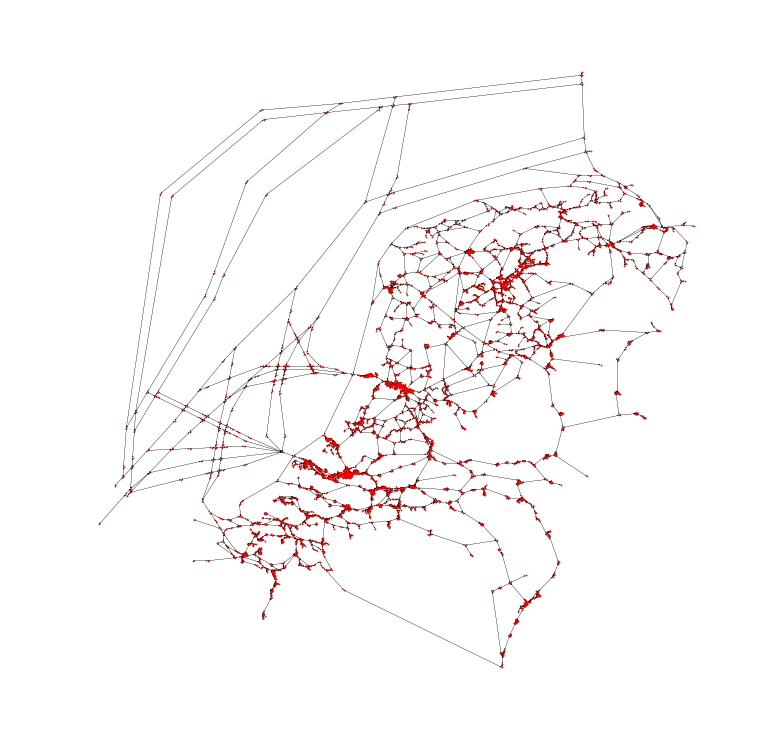

In [8]:
graph.create_graph_new_projection()
graph.plot()